/var/folders/rv/2ljdpj513xgcp83htfzd28240000gn/T/ipykernel_4944/2579571663.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year
/var/folders/rv/2ljdpj513xgcp83htfzd28240000gn/T/ipykernel_4944/2579571663.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year
/var/folders/rv/2ljdpj513xgcp83htfzd28240000gn/T/ipykernel_4944/2579571663.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Top 5 Industries Over the Past 5 Years (2019-2024):
                          Industry  Weighted Return
94                  Semiconductors         0.395848
58  Internet Content & Information         0.172519
8               Auto Manufacturers         0.134776
25            Consumer Electronics         0.125731
96       Software - Infrastructure         0.119916

Top 5 Industries Over the Past 3 Years (2021-2024):
                          Industry  Weighted Return
94                  Semiconductors         0.234629
58  Internet Content & Information         0.075801
96       Software - Infrastructure         0.046772
25            Consumer Electronics         0.037532
30    Drug Manufacturers - General         0.030163

Top 5 Industries Over the Past 1 Year (2023-2024):
                          Industry  Weighted Return
94                  Semiconductors         0.086025
58  Internet Content & Information         0.032044
96       Software - Infrastructure         0.018856
30    Drug 

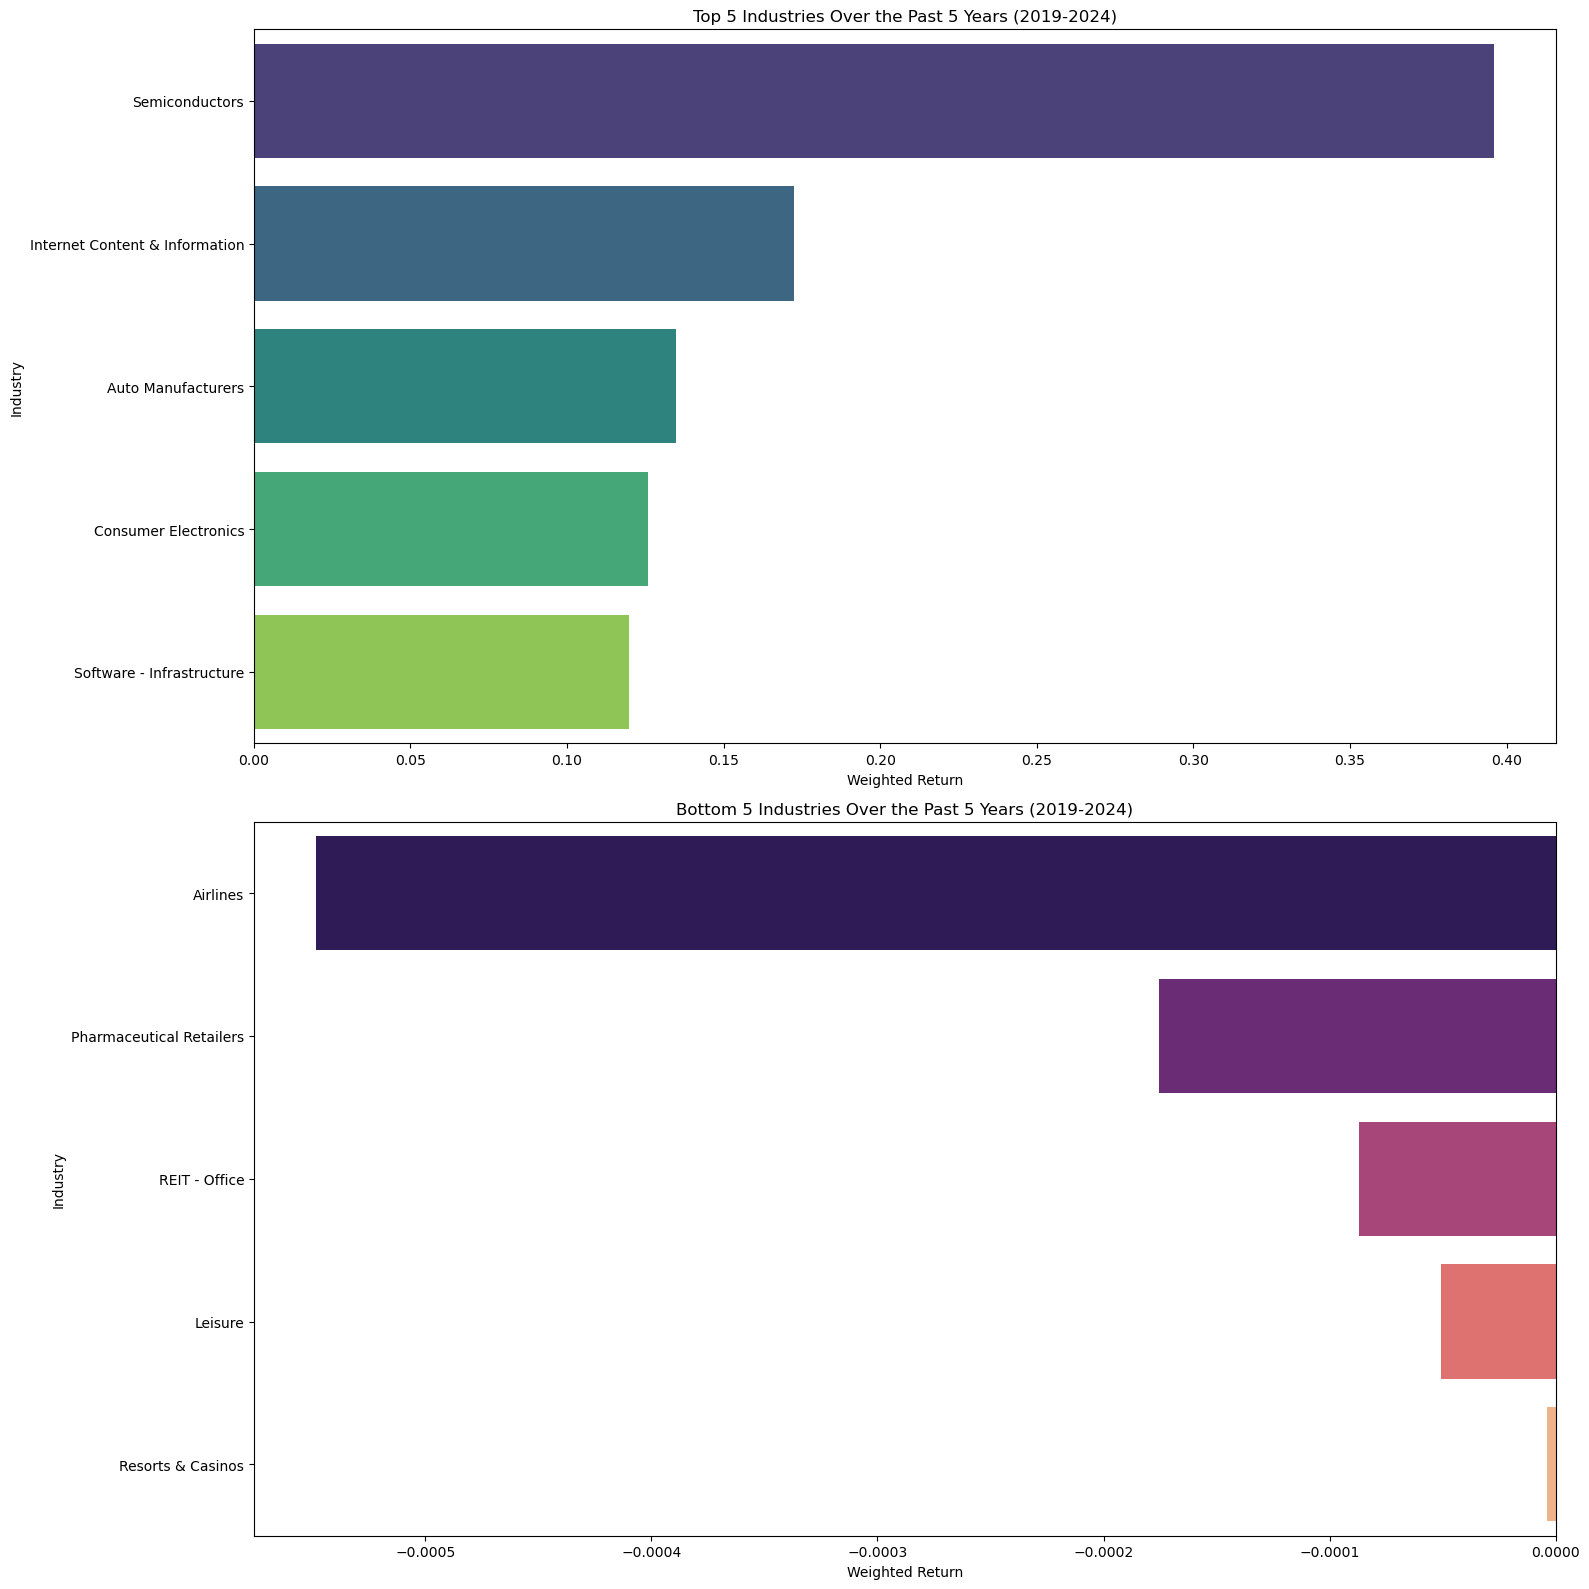

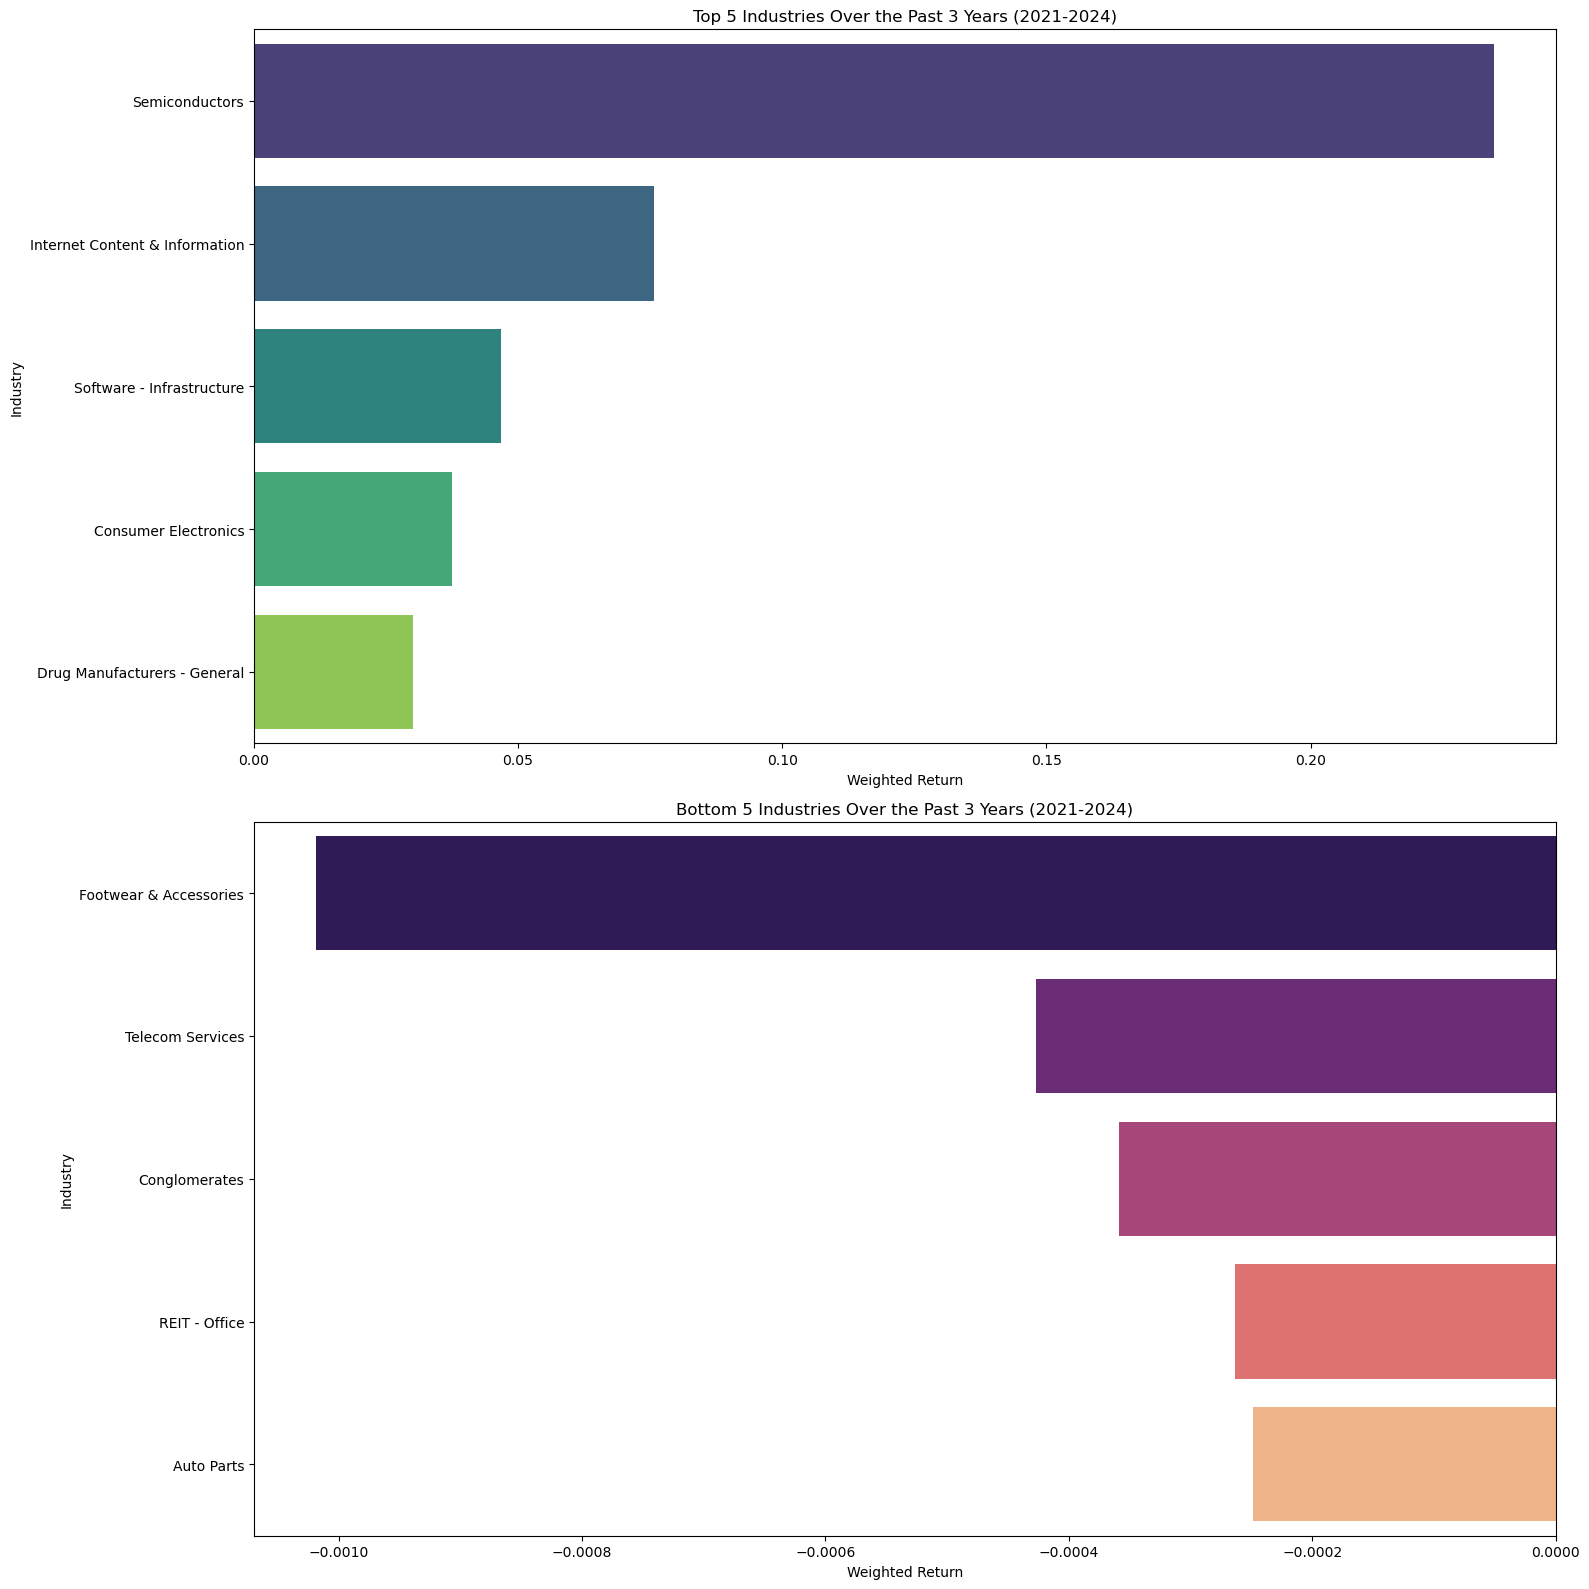

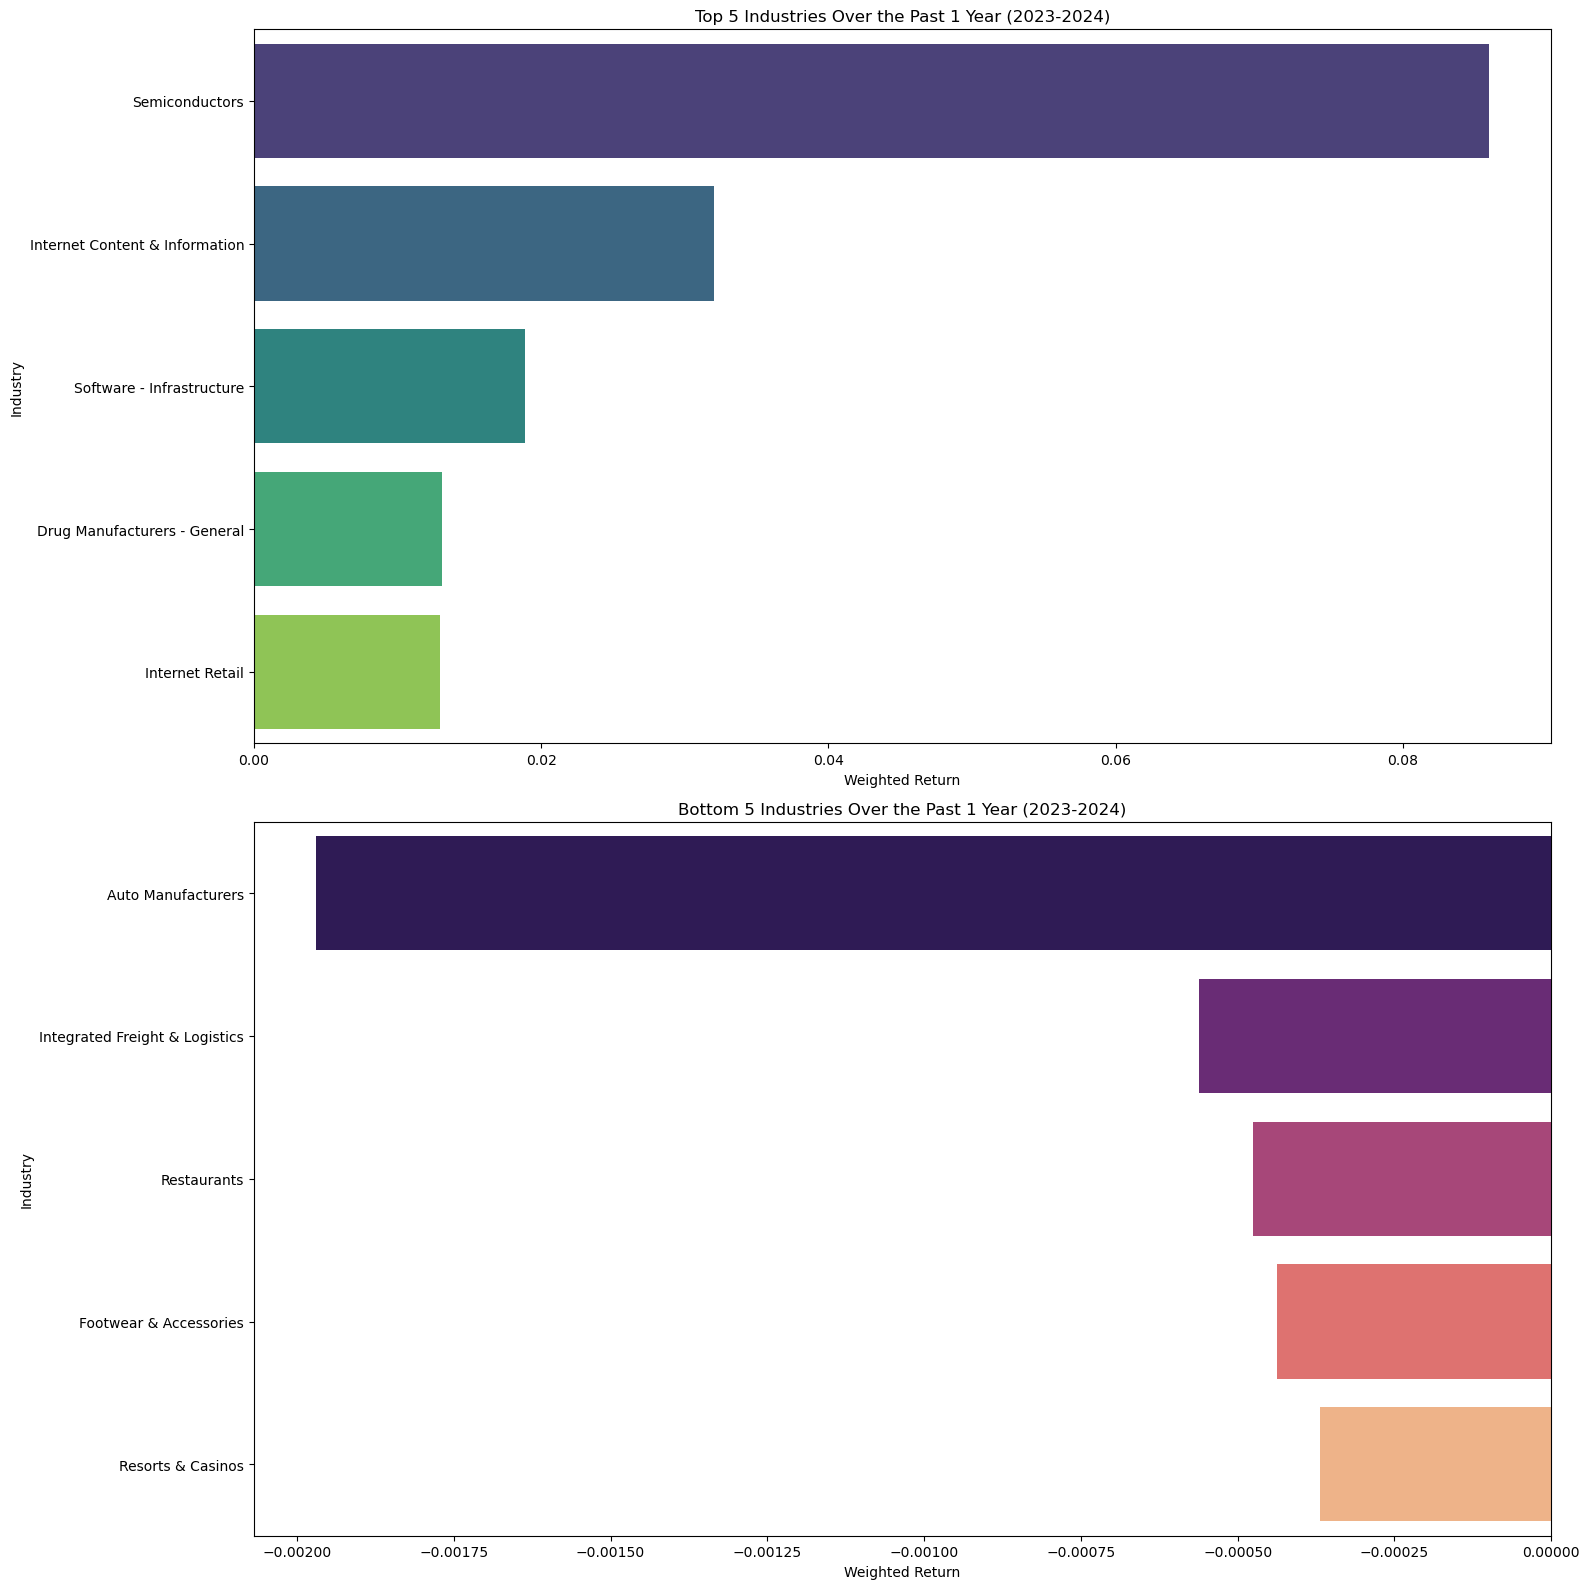

In [27]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
companies_file = '/Users/debby/Desktop/S&P500/sp500_companies.csv'
stocks_file = '/Users/debby/Desktop/S&P500/sp500_stocks.csv'

# Load the CSV files
companies_df = pd.read_csv(companies_file)
stocks_df = pd.read_csv(stocks_file)

# Ensure 'Symbol' columns are of the same type
companies_df['Symbol'] = companies_df['Symbol'].astype(str)
stocks_df['Symbol'] = stocks_df['Symbol'].astype(str)

# Fetch market cap data
market_caps = {}
for symbol in companies_df['Symbol'].tolist():
    ticker = yf.Ticker(symbol)
    try:
        market_caps[symbol] = ticker.info['marketCap']
    except KeyError:
        market_caps[symbol] = None

# Convert to DataFrame
market_cap_df = pd.DataFrame(list(market_caps.items()), columns=['Symbol', 'Market Cap'])

# Merge with companies data
companies_df = pd.merge(companies_df, market_cap_df, on='Symbol', how='left')

# Drop rows where Market Cap is None
companies_df = companies_df.dropna(subset=['Market Cap'])

# Calculate total market cap of S&P 500
total_market_cap = companies_df['Market Cap'].sum()

# Calculate weight for each company
companies_df['Weight'] = companies_df['Market Cap'] / total_market_cap

# Merge the stocks_df with companies_df to include the 'Industry' column in stocks_df
merged_df = pd.merge(stocks_df, companies_df, on='Symbol', how='left')

# Ensure 'Date' column is in datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Function to filter data by date
def filter_data_by_date(df, start_date, end_date):
    df['Date'] = pd.to_datetime(df['Date'])
    return df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Define time periods
five_years_data = filter_data_by_date(merged_df, '2019-07-31', '2024-07-31')
three_years_data = filter_data_by_date(merged_df, '2021-07-31', '2024-07-31')
one_year_data = filter_data_by_date(merged_df, '2023-07-31', '2024-07-31')

# Calculate annual returns using 'Adj Close'
def calculate_annual_returns(df):
    df['Year'] = df['Date'].dt.year
    df = df.sort_values(['Symbol', 'Date'])
    df['Previous Adj Close'] = df.groupby('Symbol')['Adj Close'].shift(1)
    df['Annual Return'] = (df['Adj Close'] - df['Previous Adj Close']) / df['Previous Adj Close']
    df = df.dropna(subset=['Annual Return'])
    df = df.groupby(['Symbol', 'Year'])['Annual Return'].apply(lambda x: (1 + x).prod() - 1).reset_index()
    return df

# Calculate annual returns for each period
annual_returns_five_years = calculate_annual_returns(five_years_data)
annual_returns_three_years = calculate_annual_returns(three_years_data)
annual_returns_one_year = calculate_annual_returns(one_year_data)

# Ensure 'Industry' is merged correctly with the annual returns data frames
def merge_with_industry(df):
    return df.merge(companies_df[['Symbol', 'Industry']], on='Symbol', how='left')

# Merge 'Industry' column
annual_returns_five_years = merge_with_industry(annual_returns_five_years)
annual_returns_three_years = merge_with_industry(annual_returns_three_years)
annual_returns_one_year = merge_with_industry(annual_returns_one_year)

# Calculate weighted average annual returns
def weighted_average_annual_returns(df, companies_df):
    df = df.merge(companies_df[['Symbol', 'Weight']], on='Symbol', how='left')
    df['Weighted Return'] = df['Annual Return'] * df['Weight']
    weighted_avg_return = df.groupby(['Industry'])['Weighted Return'].sum().reset_index()
    return weighted_avg_return

# Calculate weighted average annual returns for each period
weighted_avg_annual_returns_five_years = weighted_average_annual_returns(annual_returns_five_years, companies_df)
weighted_avg_annual_returns_three_years = weighted_average_annual_returns(annual_returns_three_years, companies_df)
weighted_avg_annual_returns_one_year = weighted_average_annual_returns(annual_returns_one_year, companies_df)

# Calculate industry performance for each period
def calculate_industry_performance(df):
    industry_performance = df.groupby('Industry')['Weighted Return'].mean().reset_index()
    return industry_performance

# Calculate industry performance for each period
industry_performance_five_years = calculate_industry_performance(weighted_avg_annual_returns_five_years)
industry_performance_three_years = calculate_industry_performance(weighted_avg_annual_returns_three_years)
industry_performance_one_year = calculate_industry_performance(weighted_avg_annual_returns_one_year)

# Identify top and bottom industries
def top_bottom_industries(df, top_n=5):
    top_industries = df.nlargest(top_n, 'Weighted Return')
    bottom_industries = df.nsmallest(top_n, 'Weighted Return')
    return top_industries, bottom_industries

# Identify top and bottom industries
top_5_five_years, bottom_5_five_years = top_bottom_industries(industry_performance_five_years)
top_5_three_years, bottom_5_three_years = top_bottom_industries(industry_performance_three_years)
top_5_one_year, bottom_5_one_year = top_bottom_industries(industry_performance_one_year)

# Print top 5 industries for each period
print("Top 5 Industries Over the Past 5 Years (2019-2024):")
print(top_5_five_years)

print("\nTop 5 Industries Over the Past 3 Years (2021-2024):")
print(top_5_three_years)

print("\nTop 5 Industries Over the Past 1 Year (2023-2024):")
print(top_5_one_year)

print("\nBottom 5 Industries Over the Past 5 Years (2019-2024):")
print(bottom_5_five_years)

print("\nBottom 5 Industries Over the Past 3 Years (2021-2024):")
print(bottom_5_three_years)

print("\nBottom 5 Industries Over the Past 1 Year (2023-2024):")
print(bottom_5_one_year)

# Find top 10 best-performing stocks in each specific industry
def top_stocks_in_specific_industries(df, industries):
    top_stocks = {}
    for industry in industries:
        industry_stocks = df[df['Industry'] == industry].drop_duplicates('Symbol')
        top_stocks[industry] = industry_stocks.nlargest(10, 'Annual Return')
    return top_stocks

# Define the specific industries for each period
industries = ['Semiconductors', 'Internet Content & Information', 'Auto Manufacturers', 'Consumer Electronics', 'Software - Infrastructure', 'Drug Manufacturers - General']

# Find top 10 best-performing stocks in each specific industry
top_10_stocks = top_stocks_in_specific_industries(annual_returns_five_years, industries)

# Print the results
print("Top 10 Best-Performing Stocks in Each Top Industry:")
for industry, stocks in top_10_stocks.items():
    print(f"\nIndustry: {industry}")
    print(stocks[['Symbol', 'Annual Return']])

# Visualization function
def visualize_industries(industry_performance, title, top_n=5):
    top_industries = industry_performance.nlargest(top_n, 'Weighted Return')
    bottom_industries = industry_performance.nsmallest(top_n, 'Weighted Return')

    fig, axes = plt.subplots(2, 1, figsize=(16, 16))

    sns.barplot(x='Weighted Return', y='Industry', data=top_industries, ax=axes[0], palette='viridis')
    axes[0].set_title(f'Top {top_n} Industries {title}')
    axes[0].set_xlabel('Weighted Return')
    axes[0].set_ylabel('Industry')

    sns.barplot(x='Weighted Return', y='Industry', data=bottom_industries, ax=axes[1], palette='magma')
    axes[1].set_title(f'Bottom {top_n} Industries {title}')
    axes[1].set_xlabel('Weighted Return')
    axes[1].set_ylabel('Industry')

    plt.tight_layout()
    plt.show()

# Visualize the top and bottom industries for each period separately
visualize_industries(industry_performance_five_years, 'Over the Past 5 Years (2019-2024)')
visualize_industries(industry_performance_three_years, 'Over the Past 3 Years (2021-2024)')
visualize_industries(industry_performance_one_year, 'Over the Past 1 Year (2023-2024)')

In [58]:
import yfinance as yf
import pandas as pd
import numpy as np

# List of stock symbols
stocks = ["QRVO", "SMLR", "NVDA", "MCHP", "MU", "NXPI", "MPWR", "AVGO", "ON", "AMD",
          "GOOG", "GOOGL", "MTCH", "META", "TSLA", "F", "GM", "AAPL", "FIVN", "CRWD",
          "OKTA", "SNOW", "ANSS", "ZS", "NOW", "ORCL", "AMGN", "ABBV",
          "MRK", "JNJ", "LLY", "BMY", "PFE", "GILD"]

# Fetch historical data from Yahoo Finance
def fetch_data(symbol):
    data = yf.download(symbol, start="2019-07-31", end="2024-07-31", auto_adjust=False)
    return data

# Calculate financial metrics
def calculate_metrics(data, start_date, end_date):
    metrics = {}
    
    # Calculate daily returns
    data['Daily Return'] = data['Adj Close'].pct_change()
    
    # Compound Annual Growth Rate (CAGR)
    beginning_value = data['Adj Close'].iloc[0]
    ending_value = data['Adj Close'].iloc[-1]
    years = (end_date - start_date).days / 365
    cagr = ((ending_value / beginning_value) ** (1 / years)) - 1
    
    # Annual Volatility
    annual_volatility = data['Daily Return'].std() * np.sqrt(252)
    
    # Sharpe Ratio
    risk_free_rate = 0.02
    sharpe_ratio = (cagr - risk_free_rate) / annual_volatility
    
    # Value at Risk (VaR)
    var_95 = np.percentile(data['Daily Return'].dropna(), 5)
    
    metrics['Annual Return (CAGR)'] = cagr
    metrics['Annual Volatility'] = annual_volatility
    metrics['Sharpe Ratio'] = sharpe_ratio
    metrics['VaR 95%'] = var_95
    
    return metrics

# Initialize an empty list to store the results
summary_list = []

# Loop through each stock
for symbol in stocks:
    try:
        data = fetch_data(symbol)
        
        # Ensure that the data structure is correct
        if 'Adj Close' not in data:
            print(f"Data for {symbol} not found")
            continue

        stock_data = data['Adj Close'].to_frame(name='Adj Close')
        
        # Define start and end dates
        start_date = stock_data.index[0]
        end_date = stock_data.index[-1]
        
        # Calculate metrics for the stock
        metrics = calculate_metrics(stock_data, start_date, end_date)
        
        # Fetch additional metrics from Yahoo Finance
        stock = yf.Ticker(symbol)
        info = stock.info
        
        # Dividend Yield
        metrics['Dividend Yield'] = info.get('dividendYield', np.nan)
        
        # EPS
        metrics['EPS'] = info.get('trailingEps', np.nan)
        
        # P/E Ratio
        metrics['P/E Ratio'] = info.get('trailingPE', np.nan)
        
        # PB Ratio
        metrics['PB Ratio'] = info.get('priceToBook', np.nan)
        
        # Future Growth (assuming it is provided in the info dictionary)
        metrics['Future Growth'] = info.get('earningsGrowth', np.nan)
        
        # Append the results to the summary list
        summary_list.append(pd.DataFrame(metrics, index=[symbol]))
    except KeyError:
        print(f"Data for {symbol} not found")

# Concatenate all the results into a single DataFrame
summary = pd.concat(summary_list)

# Display the summary dataframe
summary.reset_index(inplace=True)
summary.rename(columns={'index': 'Symbol'}, inplace=True)

# Output the summary dataframe
summary




[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,Symbol,Annual Return (CAGR),Annual Volatility,Sharpe Ratio,VaR 95%,Dividend Yield,EPS,P/E Ratio,PB Ratio,Future Growth
0,QRVO,0.102586,0.431560,0.191365,-0.040536,NaN,-0.27,NaN,3.308003,NaN
1,SMLR,-0.079789,0.647285,-0.154165,-0.051861,NaN,2.78,12.312949,3.040504,0.238
2,NVDA,0.898921,0.528740,1.662294,-0.048236,0.0004,1.71,68.821630,58.901398,6.500
3,MCHP,0.146765,0.434515,0.291740,-0.040264,0.0209,3.48,25.551723,7.167499,-0.738
4,MU,0.184044,0.454232,0.361146,-0.044627,0.0045,-1.41,NaN,2.786499,NaN
5,NXPI,0.213715,0.430439,0.450041,-0.041621,0.0161,10.69,24.709076,7.468333,-0.049
6,MPWR,0.405024,0.512996,0.750539,-0.047837,0.0064,8.36,102.683014,19.766285,-0.164
7,AVGO,0.376670,0.381824,0.934121,-0.034529,0.0146,2.33,68.497856,2.694990,1.881
8,ON,0.280042,0.565023,0.460233,-0.047654,NaN,4.39,18.003418,4.058280,-0.393
9,AMD,0.353514,0.524760,0.635556,-0.050905,NaN,0.84,173.203930,4.163675,8.553


In [60]:
import yfinance as yf
import pandas as pd
import numpy as np

# List of stock symbols
stocks = ["QRVO", "SMLR", "NVDA", "MCHP", "MU", "NXPI", "MPWR", "AVGO", "ON", "AMD",
          "GOOG", "GOOGL", "MTCH", "META", "TSLA", "F", "GM", "AAPL", "FIVN", "CRWD",
          "OKTA", "SNOW", "ANSS", "ZS", "NOW", "ORCL", "AMGN", "ABBV",
          "MRK", "JNJ", "LLY", "BMY", "PFE", "GILD"]

# Fetch historical data from Yahoo Finance
def fetch_data(symbol):
    data = yf.download(symbol, start="2019-07-31", end="2024-07-31", auto_adjust=False)
    return data

# Calculate financial metrics
def calculate_metrics(data, start_date, end_date):
    metrics = {}
    
    # Calculate daily returns
    data['Daily Return'] = data['Adj Close'].pct_change()
    
    # Compound Annual Growth Rate (CAGR)
    beginning_value = data['Adj Close'].iloc[0]
    ending_value = data['Adj Close'].iloc[-1]
    years = (end_date - start_date).days / 365.25
    cagr = ((ending_value / beginning_value) ** (1 / years)) - 1
    
    # Annual Volatility
    annual_volatility = data['Daily Return'].std() * np.sqrt(252)
    
    # Sharpe Ratio
    risk_free_rate = 0.02
    sharpe_ratio = (cagr - risk_free_rate) / annual_volatility
    
    # Value at Risk (VaR)
    var_95 = np.percentile(data['Daily Return'].dropna(), 5)
    
    metrics['Annual Return (CAGR)'] = cagr
    metrics['Annual Volatility'] = annual_volatility
    metrics['Sharpe Ratio'] = sharpe_ratio
    metrics['VaR 95%'] = var_95
    
    return metrics

# Initialize an empty list to store the results
summary_list = []

# Loop through each stock
for symbol in stocks:
    try:
        data = fetch_data(symbol)
        
        # Ensure that the data structure is correct
        if 'Adj Close' not in data:
            print(f"Data for {symbol} not found")
            continue

        stock_data = data['Adj Close'].to_frame(name='Adj Close')
        
        # Define start and end dates
        start_date = stock_data.index[0]
        end_date = stock_data.index[-1]
        
        # Calculate metrics for the stock
        metrics = calculate_metrics(stock_data, start_date, end_date)
        
        # Fetch additional metrics from Yahoo Finance
        stock = yf.Ticker(symbol)
        info = stock.info
        
        # Dividend Yield
        metrics['Dividend Yield'] = info.get('dividendYield', np.nan)
        
        # EPS
        metrics['EPS'] = info.get('trailingEps', np.nan)
        
        # P/E Ratio
        metrics['P/E Ratio'] = info.get('trailingPE', np.nan)
        
        # PB Ratio
        metrics['PB Ratio'] = info.get('priceToBook', np.nan)
        
        # Future Growth (assuming it is provided in the info dictionary)
        metrics['Future Growth'] = info.get('earningsGrowth', np.nan)
        
        # Append the results to the summary list
        summary_list.append(pd.DataFrame(metrics, index=[symbol]))
    except KeyError:
        print(f"Data for {symbol} not found")

# Concatenate all the results into a single DataFrame
summary = pd.concat(summary_list)

# Display the summary dataframe
summary.reset_index(inplace=True)
summary.rename(columns={'index': 'Symbol'}, inplace=True)

# Output the summary dataframe
summary

# Save result to your desktop
summary.to_csv('/Users/debby/Desktop/updated_stock_statistics.csv')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [62]:
# List of stock symbols
symbols = ["QRVO", "SMLR", "NVDA", "MCHP", "MU", "NXPI", "MPWR", "AVGO", "ON", "AMD",
           "GOOG", "GOOGL", "MTCH", "META", "TSLA", "F", "GM", "AAPL", "FIVN", "CRWD",
           "OKTA", "SNOW", "ANSS", "ZS", "NOW", "ORCL", "AMGN", "ABBV",
           "MRK", "JNJ", "LLY", "BMY", "PFE", "GILD"]

# Initialize an empty list to store the results
company_info = []

# Fetch company names
for symbol in symbols:
    try:
        stock = yf.Ticker(symbol)
        info = stock.info
        company_name = info.get('shortName', 'N/A')
        company_info.append({'Symbol': symbol, 'Company Name': company_name})
    except Exception as e:
        print(f"Could not retrieve data for {symbol}: {e}")
        company_info.append({'Symbol': symbol, 'Company Name': 'N/A'})

# Convert the list to a DataFrame
company_info_df = pd.DataFrame(company_info)

# Display the DataFrame
print(company_info_df)

# Save the DataFrame to a CSV file
company_info_df.to_csv('/Users/debby/Desktop/company_names.csv', index=False)

   Symbol                     Company Name
0    QRVO                      Qorvo, Inc.
1    SMLR          Semler Scientific, Inc.
2    NVDA               NVIDIA Corporation
3    MCHP  Microchip Technology Incorporat
4      MU          Micron Technology, Inc.
5    NXPI          NXP Semiconductors N.V.
6    MPWR   Monolithic Power Systems, Inc.
7    AVGO                    Broadcom Inc.
8      ON     ON Semiconductor Corporation
9     AMD     Advanced Micro Devices, Inc.
10   GOOG                    Alphabet Inc.
11  GOOGL                    Alphabet Inc.
12   MTCH                Match Group, Inc.
13   META             Meta Platforms, Inc.
14   TSLA                      Tesla, Inc.
15      F               Ford Motor Company
16     GM           General Motors Company
17   AAPL                       Apple Inc.
18   FIVN                      Five9, Inc.
19   CRWD       CrowdStrike Holdings, Inc.
20   OKTA                       Okta, Inc.
21   SNOW                   Snowflake Inc.
22   ANSS  

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

   Symbol  Predicted Price (2025-07-31)
0    QRVO                    105.254122
1    SMLR                     26.530316
2    NVDA                     79.131739
3    MCHP                     99.834514
4      MU                     99.808621
5    NXPI                    261.207706
6    MPWR                    764.283899
7    AVGO                    130.935724
8      ON                    107.866198
9     AMD                    165.503232
10   GOOG                    172.345604
11  GOOGL                    170.848235
12   MTCH                     20.176169
13   META                    380.927179
14   TSLA                    315.075929
15      F                     15.228379
16     GM                     41.936946
17   AAPL                    232.641598
18   FIVN                     62.177034
19   CRWD                    298.860709
20   OKTA                     50.873134
21   SNOW                     85.467056
22   ANSS                    330.732871
23     ZS                    228.052001


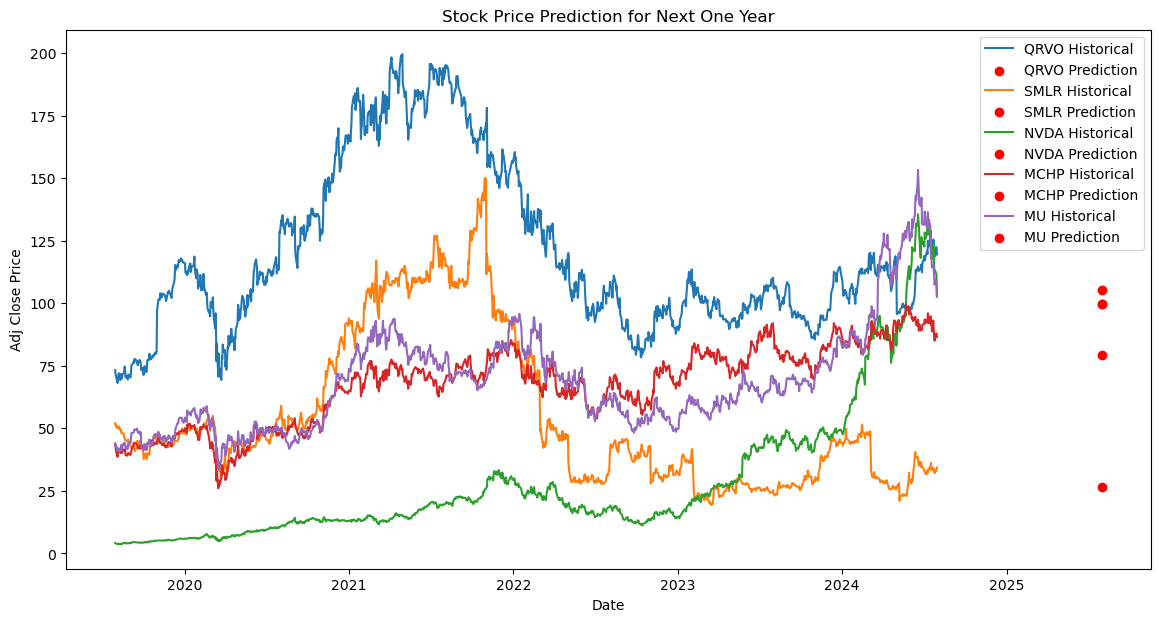

In [65]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

# List of stock symbols
symbols = ["QRVO", "SMLR", "NVDA", "MCHP", "MU", "NXPI", "MPWR", "AVGO", "ON", "AMD",
           "GOOG", "GOOGL", "MTCH", "META", "TSLA", "F", "GM", "AAPL", "FIVN", "CRWD",
           "OKTA", "SNOW", "ANSS", "ZS", "NOW", "ORCL", "AMGN", "ABBV",
           "MRK", "JNJ", "LLY", "BMY", "PFE", "GILD"]

# Function to fetch historical data from Yahoo Finance
def fetch_data(symbol):
    data = yf.download(symbol, start="2019-07-31", end="2024-07-31", auto_adjust=False)
    return data

# Function to predict next one year stock growth
def predict_stock_growth(symbol):
    data = fetch_data(symbol)
    
    if 'Adj Close' not in data:
        print(f"Data for {symbol} not found")
        return None
    
    data['Date'] = data.index
    data['Days'] = (data['Date'] - data['Date'].min()).dt.days
    
    X = data['Days'].values.reshape(-1, 1)
    y = data['Adj Close'].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    future_days = np.array([(datetime.strptime('2025-07-31', '%Y-%m-%d') - data['Date'].min()).days]).reshape(-1, 1)
    prediction = model.predict(future_days)
    
    return prediction[0]

# Initialize an empty list to store the predictions
predictions = []

# Loop through each stock and predict the next one year growth
for symbol in symbols:
    try:
        predicted_price = predict_stock_growth(symbol)
        predictions.append({'Symbol': symbol, 'Predicted Price (2025-07-31)': predicted_price})
    except Exception as e:
        print(f"Could not predict for {symbol}: {e}")

# Convert the list to a DataFrame
predictions_df = pd.DataFrame(predictions)

# Display the predictions dataframe
print(predictions_df)

# Save the predictions to a CSV file
predictions_df.to_csv('/Users/debby/Desktop/stock_predictions.csv', index=False)

# Visualize the predictions
plt.figure(figsize=(14, 7))
for symbol in symbols[:5]:  # Visualize only the first 5 stocks for clarity
    data = fetch_data(symbol)
    if 'Adj Close' not in data:
        continue
    
    data['Date'] = data.index
    data['Days'] = (data['Date'] - data['Date'].min()).dt.days
    
    X = data['Days'].values.reshape(-1, 1)
    y = data['Adj Close'].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    future_days = np.array([(datetime.strptime('2025-07-31', '%Y-%m-%d') - data['Date'].min()).days]).reshape(-1, 1)
    prediction = model.predict(future_days)
    
    plt.plot(data['Date'], data['Adj Close'], label=f'{symbol} Historical')
    plt.scatter([datetime.strptime('2025-07-31', '%Y-%m-%d')], prediction, label=f'{symbol} Prediction', color='red')
    
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title('Stock Price Prediction for Next One Year')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

   Symbol  Current Price (2024-07-31)  Predicted Price (2025-07-31)
0    QRVO                  119.459999                    105.254122
1    SMLR                   34.349998                     26.530316
2    NVDA                  103.730003                     79.131739
3    MCHP                   86.540001                     99.834514
4      MU                  102.559998                     99.808621
5    NXPI                  251.679993                    261.207706
6    MPWR                  781.849976                    764.283899
7    AVGO                  143.520004                    130.935724
8      ON                   73.970001                    107.866198
9     AMD                  138.440002                    165.503232
10   GOOG                  171.860001                    172.345604
11  GOOGL                  170.289993                    170.848235
12   MTCH                   33.689999                     20.176169
13   META                  463.190002           

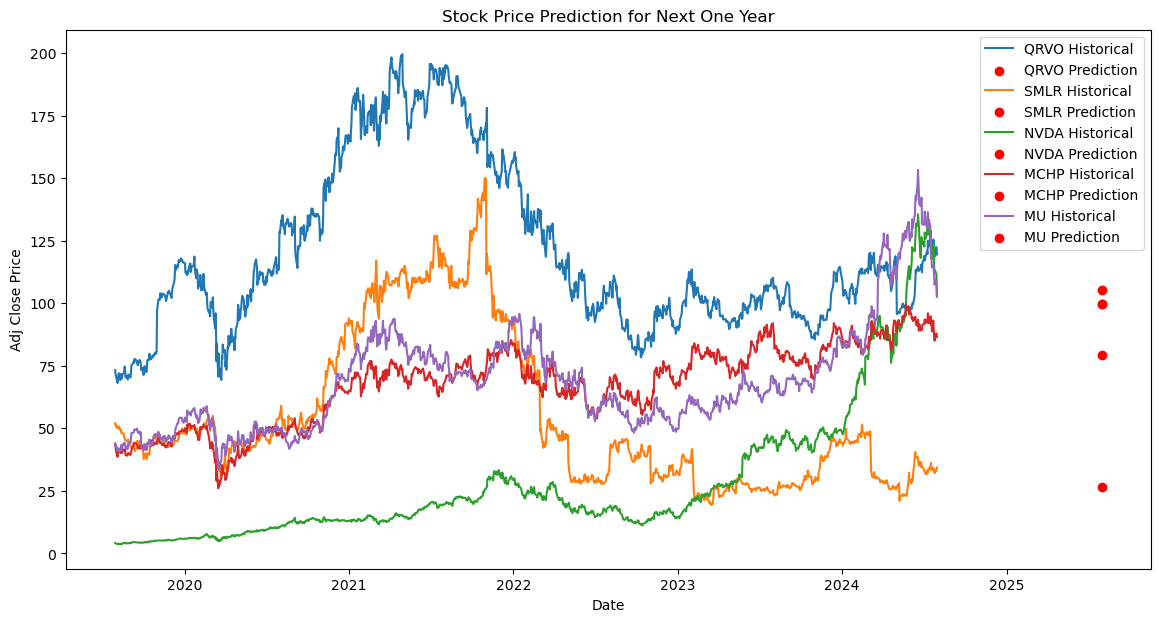

In [66]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

# List of stock symbols
symbols = ["QRVO", "SMLR", "NVDA", "MCHP", "MU", "NXPI", "MPWR", "AVGO", "ON", "AMD",
           "GOOG", "GOOGL", "MTCH", "META", "TSLA", "F", "GM", "AAPL", "FIVN", "CRWD",
           "OKTA", "SNOW", "ANSS", "ZS", "NOW", "ORCL", "AMGN", "ABBV",
           "MRK", "JNJ", "LLY", "BMY", "PFE", "GILD"]

# Function to fetch historical data from Yahoo Finance
def fetch_data(symbol):
    data = yf.download(symbol, start="2019-07-31", end="2024-07-31", auto_adjust=False)
    return data

# Function to predict next one year stock growth
def predict_stock_growth(symbol):
    data = fetch_data(symbol)
    
    if 'Adj Close' not in data:
        print(f"Data for {symbol} not found")
        return None, None
    
    data['Date'] = data.index
    data['Days'] = (data['Date'] - data['Date'].min()).dt.days
    
    X = data['Days'].values.reshape(-1, 1)
    y = data['Adj Close'].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    future_days = np.array([(datetime.strptime('2025-07-31', '%Y-%m-%d') - data['Date'].min()).days]).reshape(-1, 1)
    prediction = model.predict(future_days)
    
    current_price = data['Adj Close'].iloc[-1]
    
    return current_price, prediction[0]

# Initialize an empty list to store the predictions
predictions = []

# Loop through each stock and predict the next one year growth
for symbol in symbols:
    try:
        current_price, predicted_price = predict_stock_growth(symbol)
        predictions.append({'Symbol': symbol, 'Current Price (2024-07-31)': current_price, 'Predicted Price (2025-07-31)': predicted_price})
    except Exception as e:
        print(f"Could not predict for {symbol}: {e}")

# Convert the list to a DataFrame
predictions_df = pd.DataFrame(predictions)

# Display the predictions dataframe
print(predictions_df)

# Save the predictions to a CSV file
desktop_path = '/Users/debby/Desktop/stock_predictions.csv'  # Replace <your_actual_username> with your actual username
predictions_df.to_csv(desktop_path, index=False)

# Visualize the predictions
plt.figure(figsize=(14, 7))
for symbol in symbols[:5]:  # Visualize only the first 5 stocks for clarity
    data = fetch_data(symbol)
    if 'Adj Close' not in data:
        continue
    
    data['Date'] = data.index
    data['Days'] = (data['Date'] - data['Date'].min()).dt.days
    
    X = data['Days'].values.reshape(-1, 1)
    y = data['Adj Close'].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    future_days = np.array([(datetime.strptime('2025-07-31', '%Y-%m-%d') - data['Date'].min()).days]).reshape(-1, 1)
    prediction = model.predict(future_days)
    
    plt.plot(data['Date'], data['Adj Close'], label=f'{symbol} Historical')
    plt.scatter([datetime.strptime('2025-07-31', '%Y-%m-%d')], prediction, label=f'{symbol} Prediction', color='red')
    
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title('Stock Price Prediction for Next One Year')
plt.legend()
plt.show()